In [1]:
from burstextractor.burstlist import download_burst_list, process_burst_list
from burstextractor.timeutils import extract_time, fix_typos_in_time, fix_24_hour_time, create_datetime, check_valid_date, adjust_year_month
from burstextractor.data_utils import explode_instruments_long_clean_instruments, keep_only_type_I_to_VI
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

## Create Dataframe with the Burstlists

In [2]:
years = [2021, 2022, 2023]
months = range(1, 12+1)
burst_lists = []
for year in years:
    for month in months:
        if month > datetime.datetime.now().month and year == datetime.datetime.now().year:
            break
        download_burst_list(year, month)
        burst_lists.append(process_burst_list(f"e-CALLISTO_{year}_{month:02}.txt"))
burst_list = pd.concat(burst_lists).reset_index(drop=True)

/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)
/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)


In [3]:
burst_list.sample(5)

,date,time,type,instruments
3797,20220922,02:52-02:54,III,"ALASKA-COHOE, (ALASKA-HAARP), Australia-ASSA, ..."
4694,20221231,08:10-08:14,III,"ALMATY, AUSTRIA-UNIGRAZ, Australia-ASSA, GERMA..."
4223,20221112,11:37-11:47,VI,"AUSTRIA-UNIGRAZ, GERMANY-DLR, ((GLASGOW)), HUM..."
976,20211025,18:05-18:05,III,"ALASKA-HAARP, Arecibo-Observatory"
3436,20220805,13:25-13:26,III,"(Arecibo-Observatory), GLASGOW, SWISS-Landschl..."


In [4]:
burst_list.shape

(4750, 4)

## Fix typos

In [5]:
extracted_digits = burst_list['time'].str.extract(r'(\d+).(\d+).(\d+).(\d+)', expand=True).astype(int)

In [6]:
impossible_times_bool = (extracted_digits[1] > 59) | (extracted_digits[3] > 59) | (extracted_digits[0] > 23) | (extracted_digits[2] > 23)
extracted_digits[impossible_times_bool]

,0,1,2,3
1693,6,6,6,88
2238,24,32,14,33
3876,23,59,24,0
3890,0,0,24,0
3920,3,50,24,0
4179,23,59,24,0
4467,23,58,24,0
4557,0,0,24,0
4576,0,0,24,0


In [7]:
burst_list[impossible_times_bool]

,date,time,type,instruments
1693,20220210,06:06-06:88,V,"ALMATY, Australia-ASSA, INDIA-OOTY, INDIA-UDAI..."
2238,20220421,24:32-14:33,III,"AUSTRIA-MICHELBACH, Arecibo-Observatory, GLASG..."
3876,20220926,23:59:24:00,III,"ALASKA-COHOE, ALASKA-HAARP, Australia-ASSA"
3890,20220929,00:00-24:00,NaN,CTM
3920,20221001,03:50-24:00,CTM,*
4179,20221110,23:59-24:00,III,"ALASKA-COHOE, Australia-ASSA"
4467,20221215,23:58-24:00,III,Arecibo-Observatory
4557,20221221,00:00-24:00,CTM,*
4576,20221222,00:00-24:00,CTM,*


In [8]:
burst_list.loc[4179]

date                               20221110
time                            23:59-24:00
type                                    III
instruments    ALASKA-COHOE, Australia-ASSA
Name: 4179, dtype: object

In [9]:
burst_list.loc[4179+1]

date                 20221111
time              00:02-00:14
type                       VI
instruments    Australia-ASSA
Name: 4180, dtype: object

In [10]:
burst_list = fix_typos_in_time(burst_list)
burst_list = extract_time(burst_list)
burst_list = fix_24_hour_time(burst_list)
burst_list = create_datetime(burst_list)
burst_list = explode_instruments_long_clean_instruments(burst_list)
burst_list = keep_only_type_I_to_VI(burst_list)

In [11]:
burst_list.sample(5)

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
19393,20221011,11:01-11:11,II,AUSTRIA-UNIGRAZ,11:01,11:11,20221011,20221011,2022-10-11 11:01:00,2022-10-11 11:11:00
22130,20221225,08:29-08:42,VI,Australia-ASSA,08:29,08:42,20221225,20221225,2022-12-25 08:29:00,2022-12-25 08:42:00
380,20210506,14:02-14:02,III,GLASGOW,14:02,14:02,20210506,20210506,2021-05-06 14:02:00,2021-05-06 14:02:00
7140,20220304,12:05-12:08,III,AUSTRIA-UNIGRAZ,12:05,12:08,20220304,20220304,2022-03-04 12:05:00,2022-03-04 12:08:00
9124,20220421,09:26-09:29,III,(EGYPT-Alexandria),09:26,09:29,20220421,20220421,2022-04-21 09:26:00,2022-04-21 09:29:00


## EDA

In [12]:
burst_list['duration'] = burst_list['datetime_end'] - burst_list['datetime_start']

In [13]:
# Mean duration of bursts in minutes
(burst_list.duration.dt.total_seconds()/60).describe().astype(int)

count    21556
mean         9
std         76
min       -479
25%          0
50%          1
75%          5
max       1439
Name: duration, dtype: int64

In [14]:
burst_list = burst_list[burst_list.duration.dt.total_seconds() > 0]
burst_list = burst_list.explode('instruments')
burst_list.instruments = burst_list.instruments.str.strip()

In [15]:
burst_list

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end,duration
18,20210223,05:43-05:44,III,KRIM,05:43,05:44,20210223,20210223,2021-02-23 05:43:00,2021-02-23 05:44:00,0 days 00:01:00
29,20210227,17:58-18:01,III,ALASKA-HAARP,17:58,18:01,20210227,20210227,2021-02-27 17:58:00,2021-02-27 18:01:00,0 days 00:03:00
30,20210227,17:58-18:01,III,GREENLAND,17:58,18:01,20210227,20210227,2021-02-27 17:58:00,2021-02-27 18:01:00,0 days 00:03:00
31,20210227,18:07-18:08,III,GREENLAND,18:07,18:08,20210227,20210227,2021-02-27 18:07:00,2021-02-27 18:08:00,0 days 00:01:00
32,20210228,06:45-06:51,III,ALMATY,06:45,06:51,20210228,20210228,2021-02-28 06:45:00,2021-02-28 06:51:00,0 days 00:06:00
...,...,...,...,...,...,...,...,...,...,...,...
22583,20230104,23:14-23:15,III,(MEXICO-LANCE),23:14,23:15,20230104,20230104,2023-01-04 23:14:00,2023-01-04 23:15:00,0 days 00:01:00
22587,20230105,04:34-04:35,III,Australia-ASSA,04:34,04:35,20230105,20230105,2023-01-05 04:34:00,2023-01-05 04:35:00,0 days 00:01:00
22588,20230105,04:34-04:35,III,(INDIA-OOTY),04:34,04:35,20230105,20230105,2023-01-05 04:34:00,2023-01-05 04:35:00,0 days 00:01:00
22589,20230105,04:34-04:35,III,(MONGOLIA-UB),04:34,04:35,20230105,20230105,2023-01-05 04:34:00,2023-01-05 04:35:00,0 days 00:01:00


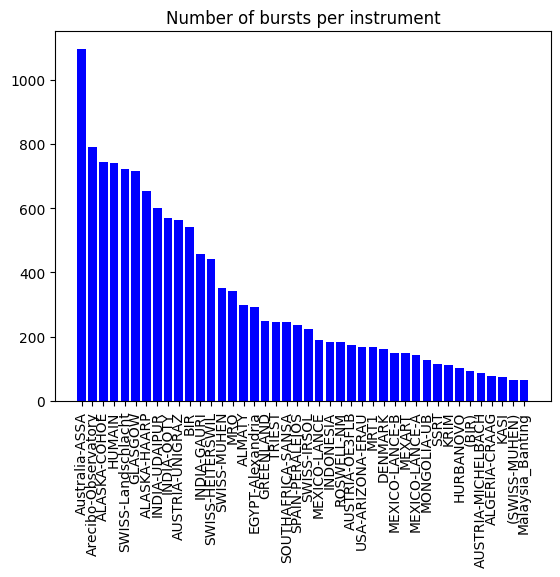

In [16]:
instrument_count = burst_list.instruments.value_counts()
instrument_count = instrument_count[instrument_count > 60]
plt.bar(instrument_count.index, instrument_count.values, color='blue')
plt.xticks(rotation=90)
plt.title('Number of bursts per instrument')
plt.show()

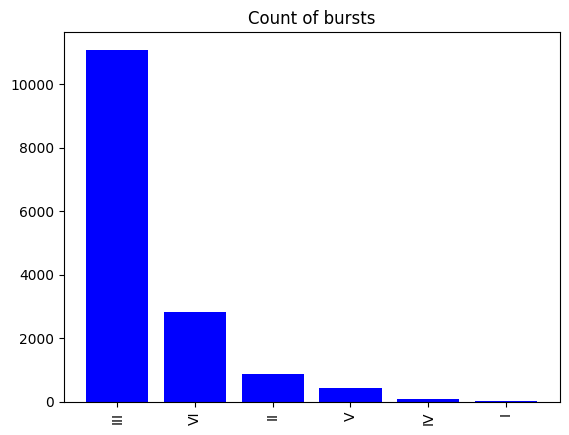

In [17]:
type_count = burst_list.type.value_counts()
plt.bar(type_count.index, type_count.values, color='blue')
plt.xticks(rotation=90)
plt.title('Count of bursts')
plt.show()

<AxesSubplot: title={'center': 'Type per top 10 instruments'}, xlabel='instruments'>

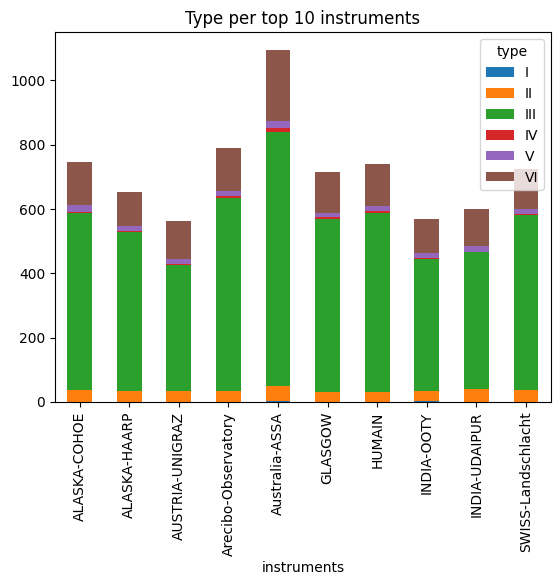

In [18]:
# Type per top 10 instruments
burst_list[burst_list.instruments.isin(instrument_count.index[:10])].groupby(['instruments', 'type']).size().unstack().plot(kind='bar', stacked=True, title='Type per top 10 instruments')

In [21]:
burst_list.duration

18      0 days 00:01:00
29      0 days 00:03:00
30      0 days 00:03:00
31      0 days 00:01:00
32      0 days 00:06:00
              ...      
22583   0 days 00:01:00
22587   0 days 00:01:00
22588   0 days 00:01:00
22589   0 days 00:01:00
22590   0 days 00:01:00
Name: duration, Length: 15337, dtype: timedelta64[ns]

In [29]:
burst_list.groupby('type').duration.mean()

type
I     0 days 00:12:14.482758620
II    0 days 00:13:07.887640449
III   0 days 00:02:57.768751692
IV              0 days 00:45:34
V     0 days 00:04:03.724137931
VI    0 days 00:56:57.164179104
Name: duration, dtype: timedelta64[ns]

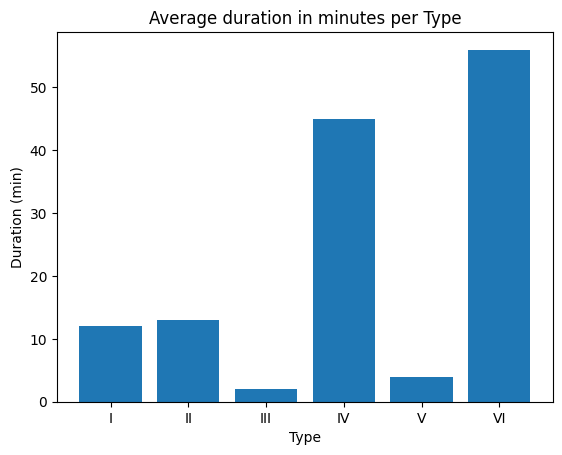

In [42]:
# Average duration per type of burst
avg_duration_type = burst_list.groupby('type').duration.mean().dt.seconds // 60
plt.bar(avg_duration_type.index, avg_duration_type)
plt.xlabel('Type')
plt.ylabel('Duration (min)')
plt.title('Average duration in minutes per Type')
plt.show()

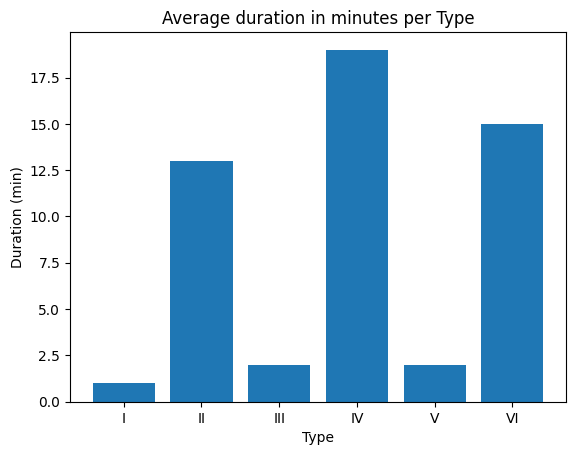

In [43]:
median_duration_type = burst_list.groupby('type').duration.median().dt.seconds // 60
plt.bar(median_duration_type.index, median_duration_type)
plt.xlabel('Type')
plt.ylabel('Duration (min)')
plt.title('Average duration in minutes per Type')
plt.show()

## Get some spectograms

In [45]:
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename

In [47]:
URL = 'http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/01/01/ALASKA-ANCHORAGE_20230101_000904_01.fit.gz'
Table.read(URL, format='fits')

TIME,FREQUENCY
float64[3600],float64[200]
0.0 .. 899.75,65.875 .. 5.0


In [51]:
from radiospectra.sources import CallistoSpectrogram

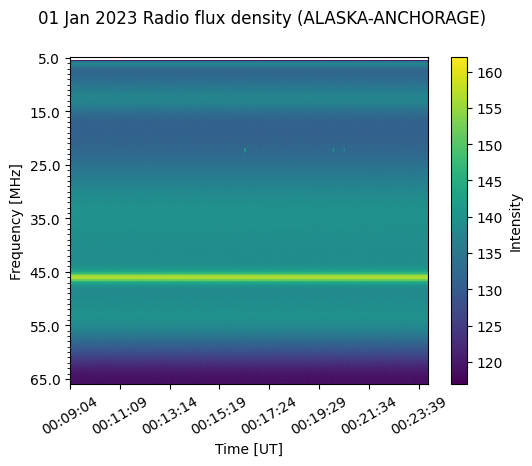

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [52]:
spec = CallistoSpectrogram.read(URL)
spec.peek()

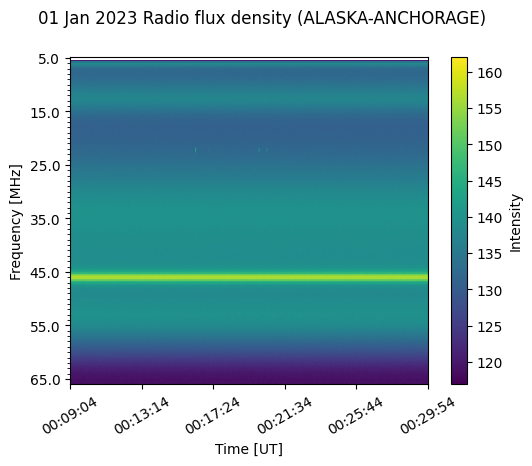

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [57]:
spec = spec.extend(-1)
spec.peek()

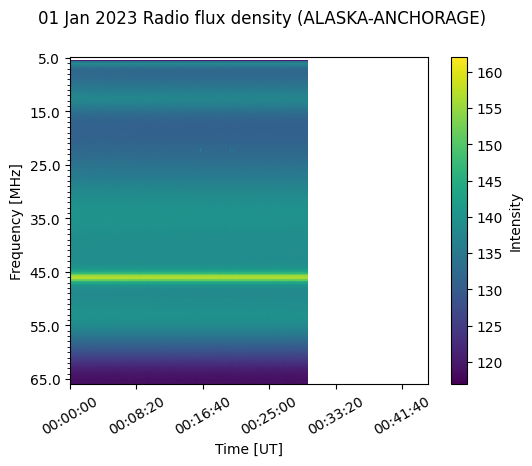

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [63]:
spec = CallistoSpectrogram.from_range('ALASKA-ANCHORAGE', '2023-01-01T00:00:00', '2023-01-01T00:33:00')
spec.peek()

In [71]:
spec.data

masked_array(
  data=[[118., 120., 119., ...,  nan,  nan,  nan],
        [119., 118., 120., ...,  nan,  nan,  nan],
        [118., 119., 119., ...,  nan,  nan,  nan],
        ...,
        [120., 120., 120., ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],
  mask=False,
  fill_value=1e+20)

In [73]:
spec.time_axis

array([0.000000e+00, 2.500000e-01, 5.000000e-01, ..., 1.581225e+04,
       1.581250e+04, 1.581275e+04])